# Modelo de Simulación de Formación de Opinion

In [1]:
# Importamos las librerias necesarias
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [167]:
# Creamos una clase para la simulación de la formación de opiniones
class OpinionFormationSimulation:
    def __init__(self, L, N, m, mu, P, P_tol="1.0", mode="equal", tol_range=(0, 1), leaders=False, leaders_op=1, num_leaders=5, seed=None):
        """
        Inicializa la simulación de formación de opinión.
        
        :param L: Tamaño del lattice LxL
        :param N: Número de pasos de la simulación
        :param m: Probabilidad de interacción con la propaganda
        :param mu: Parámetro de interacción (fuerza de la influencia)
        :param P: Valor de la propaganda
        :param P_tol: Tolerancia (efectividad) de la propaganda
        :param mode: Modo de interacción ('equal' o 'propor')
        :param tol_range: Rango de tolerancia para los agentes
        :param leaders: Booleano para activar la presencia de líderes
        :param leaders_op: Opinión de los líderes
        :param num_leaders: Número de líderes por lado del lattice
        """
        self.L = L
        self.N = N
        self.m = m
        self.mu = mu
        self.P = P
        self.P_tol = P_tol
        self.mode = mode
        self.tol_range = tol_range
        self.leaders = leaders
        self.leaders_op = leaders_op
        self.num_leaders = num_leaders
        
        # Inicializar opiniones y tolerancias
        self.opinions = np.random.random((L, L))
        self.tolerances = np.random.uniform(*tol_range, (L, L))
        
        # Colocar líderes si está activada la opción
        if self.leaders:
            self._place_leaders()
        
        # Inicializar el historial de opiniones
        self.opinion_history = [self.opinions.copy()]
    
    def _place_leaders(self):
        """
        Coloca líderes equiespaciados en el lattice.
        Los líderes tienen tolerancia 0 y opiniones aleatorias.
        """
        # Calcular el espaciado entre líderes
        spacing = self.L // (self.num_leaders + 1)
        
        for i in range(1, self.num_leaders + 1):
            for j in range(1, self.num_leaders + 1):
                x = i * spacing
                y = j * spacing
                # Colocar un líder en (x, y)
                self.tolerances[x, y] = 0
                # Asignar una opinión al líder
                self.opinions[x, y] = self.leaders_op
    
    def interact(self, opinion, other_opinion, tolerance, other_tolerance, mode='equal'):
        """
        Simula la interacción entre dos agentes o un agente y la propaganda.
        
        :param opinion: Opinión del agente actual
        :param other_opinion: Opinión del otro agente o de la propaganda
        :param tolerance: Tolerancia del agente actual
        :param other_tolerance: Tolerancia del otro agente o de la propaganda
        :param mode: Modo de interacción ('equal' o 'propor')
        :return: Nueva opinión del agente actual después de la interacción
        """
        if tolerance == 0:  # Si es un líder, no cambia de opinión
            return opinion
        if abs(opinion - other_opinion) < tolerance:
            if mode == 'equal':
                return opinion + self.mu * (other_opinion - opinion)
            elif mode == 'propor':
                return opinion + np.abs(tolerance - other_tolerance)/(tolerance + other_tolerance) * (other_opinion - opinion)
        return opinion
    
    def step(self):
        """
        Realiza un paso de la simulación, actualizando las opiniones de todos los agentes.
        """
        new_opinions = self.opinions.copy()
        for i in range(self.L):
            for j in range(self.L):
                if self.tolerances[i, j] == 0:  # Si es un líder, no cambia de opinión
                    continue
                if np.random.random() < self.m:
                    # Interacción con la propaganda
                    new_opinions[i, j] = self.interact(self.opinions[i, j], self.P, self.tolerances[i, j], self.P_tol, mode=self.mode)
                else:
                    # Interacción con los vecinos
                    neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]
                    for ni, nj in neighbors:
                        if 0 <= ni < self.L and 0 <= nj < self.L:
                            new_opinions[i, j] = self.interact(new_opinions[i, j], self.opinions[ni, nj], self.tolerances[i, j], self.tolerances[ni, nj], mode=self.mode)
        
        self.opinions = new_opinions
        self.opinion_history.append(self.opinions.copy())
    
    def run_simulation(self):
        """
        Ejecuta la simulación completa durante N pasos.
        """
        for _ in range(self.N):
            self.step()
    
    def plot_evolution(self, equal_steps = True):
        """
        Genera un gráfico de la evolución de las opiniones en cuatro momentos de la simulación.
        
        :return: Figura de matplotlib con los gráficos
        """
        fig, axes = plt.subplots(2, 2, figsize=(10, 8))
        axes = axes.flatten()
        
        # Título general del gráfico
        fig.suptitle(f"Evolución de opiniones para L={self.L}, N={self.N}, m={self.m}, mu={self.mu}, P={self.P}" + 
                     (f", con {self.num_leaders}x{self.num_leaders} líderes" if self.leaders else ""))

        # Seleccionar pasos para graficar (inicio, 1/3, 2/3, final)
        if equal_steps:
            steps_to_plot = [0, self.N // 3, 2 * self.N // 3, -1]
        else:
            steps_to_plot = [0, 10, 20, -1]
        
        # Obtener las posiciones de los líderes si están presentes
        leader_positions = []
        if self.leaders:
            spacing = self.L // (self.num_leaders + 1)
            leader_positions = [(i * spacing, j * spacing) 
                                for i in range(1, self.num_leaders + 1)
                                for j in range(1, self.num_leaders + 1)]
        
        for i, step in enumerate(steps_to_plot):
            ax = axes[i]
            im = ax.imshow(self.opinion_history[step], cmap='bwr', vmin=0, vmax=1)
            ax.set_title(f"Paso {step if step != -1 else self.N}")
            fig.colorbar(im, ax=ax)

            # Resaltar las posiciones de los líderes si están presentes
            if self.leaders:
                for x, y in leader_positions:
                    ax.plot(y, x, 'ko', markersize=8, markerfacecolor='none')  # Círculo negro
                    ax.plot(y, x, 'kx', markersize=6)  # Cruz negra
        
        plt.tight_layout()
        # plt.show()
        return fig

    
    # Función para graficar el histograma de las opiniones finales
    def plot_histogram(self):
        # plt.figure(figsize=(10, 6))
        fig, ax = plt.subplots(figsize=(10, 6))
        # plt.hist(self.opinions.flatten(), bins=40, range=(0, 1), edgecolor='black') # Graficar histograma
        ax.hist(self.opinions.flatten(), bins=40, range=(0, 1), edgecolor='black') # Graficar histograma
        if self.leaders:
            plt.title("Distribución final de opiniones con lideres")
        else:
            plt.title("Distribución final de opiniones")
        plt.xlabel("Opinión")
        plt.ylabel("Frecuencia")
        # plt.show()
        return fig
    
    # Función para graficar la evolución de la opinión de un punto
    def plot_point_evolution(self, i, j):
        # Obtener la evolución de la opinión del punto (i, j)
        point_evolution = [history[i, j] for history in self.opinion_history]
        # Graficar la evolución
        plt.figure(figsize=(10, 6))
        plt.plot(point_evolution)
        plt.title(f"Evolución de la opinión en ({i}, {j})")
        plt.xlabel("Paso")
        plt.ylabel("Opinión")
        # plt.show()
        return plt.gcf()
    
    # Función para graficar el scatter de las opiniones por paso
    def plot_scatter(self, color="black", alpha=0.2, s=1):
        # Crear un scatter plot de las opiniones
        fig, ax = plt.subplots(figsize=(10, 6))
        for i, opinions in enumerate(self.opinion_history):
            ax.scatter([i] * self.L**2, opinions.flatten(), c=color, s=1, alpha=alpha)
        ax.set_title("Evolución de opiniones")
        ax.set_xlabel("Paso")
        ax.set_ylabel("Opinión")
        # plt.show()
        return fig


    # Función para animar la evolución del sistema
    def create_animation(self, save_path, interval=50, fps=10):
        """
        Crea una animación de la evolución de las opiniones y la guarda en la ruta especificada.
        
        :param save_path: Ruta donde se guardará el archivo de animación (debe terminar en .mp4)
        :param interval: Intervalo entre frames en milisegundos
        :param fps: Frames por segundo para el video guardado
        """
        fig, ax = plt.subplots()
        
        # Inicializar la imagen
        im = ax.imshow(self.opinion_history[0], cmap='bwr', animated=True, vmin=0, vmax=1)

        # Agregar el contador de frames
        ax.text(0.02, 0.02, "Frame: 0", transform=ax.transAxes)

        # Obtener las posiciones de los líderes si están presentes
        leader_positions = []
        if self.leaders:
            spacing = self.L // (self.num_leaders + 1)
            leader_positions = [(i * spacing, j * spacing) 
                                for i in range(1, self.num_leaders + 1)
                                for j in range(1, self.num_leaders + 1)]
            for x, y in leader_positions:
                ax.plot(y, x, 'ko', markersize=8, markerfacecolor='none')  # Círculo negro
                ax.plot(y, x, 'kx', markersize=6)  # Cruz negra
        
        
        # Función de actualización para la animación
        def update(frame):
            im.set_array(self.opinion_history[frame])
            ax.texts[0].set_text(f"Frame: {frame}")
            return [im]
        
        # Crear la animación
        anim = animation.FuncAnimation(fig, update, frames=len(self.opinion_history), 
                                       interval=interval, blit=True)
        
        # Agregar una barra de color
        plt.colorbar(im)
        
        # Configurar el título
        # ax.set_title("Evolución de las opiniones para " + f"L={self.L}, N={self.N}, m={self.m}, mu={self.mu}, P={self.P}")
        if self.leaders:
            fig.suptitle("Evolución de opiniones para " + f"L={self.L}, N={self.N}, m={self.m}, mu={self.mu}, P={self.P}" + 
                         f", con {self.num_leaders}x{self.num_leaders} líderes")
        else:
            fig.suptitle("Evolución de opiniones para " + f"L={self.L}, N={self.N}, m={self.m}, mu={self.mu}, P={self.P}")

        # Guardar la animación
        anim.save(save_path, fps=fps)
        
        plt.close(fig)
        print(f"Animación guardada en {save_path}")

In [206]:
# Ejemplo de uso
L = 50  # Tamaño del lattice
N = 100  # Número de pasos de simulación
m = 0.2  # Probabilidad de interacción con propaganda
mu = 0.1  # Parámetro de interacción
P = 0.5  # Valor de la propaganda
tol_range = (0.0, 1.0)  # Rango de tolerancias

# Simulación sin líderes
# simulation_no_leaders = OpinionFormationSimulation(L, N, m, mu, P, tol_range=tol_range)
simulation_no_leaders = OpinionFormationSimulation(L, N, m, mu, P, leaders=True, leaders_op=1, num_leaders=7)
simulation_no_leaders.run_simulation()

# Simulación con líderes
# simulation_with_leaders = OpinionFormationSimulation(L, N, m, mu, P, leaders=True, leaders_op=1-P, num_leaders=2)
# simulation_with_leaders.run_simulation()

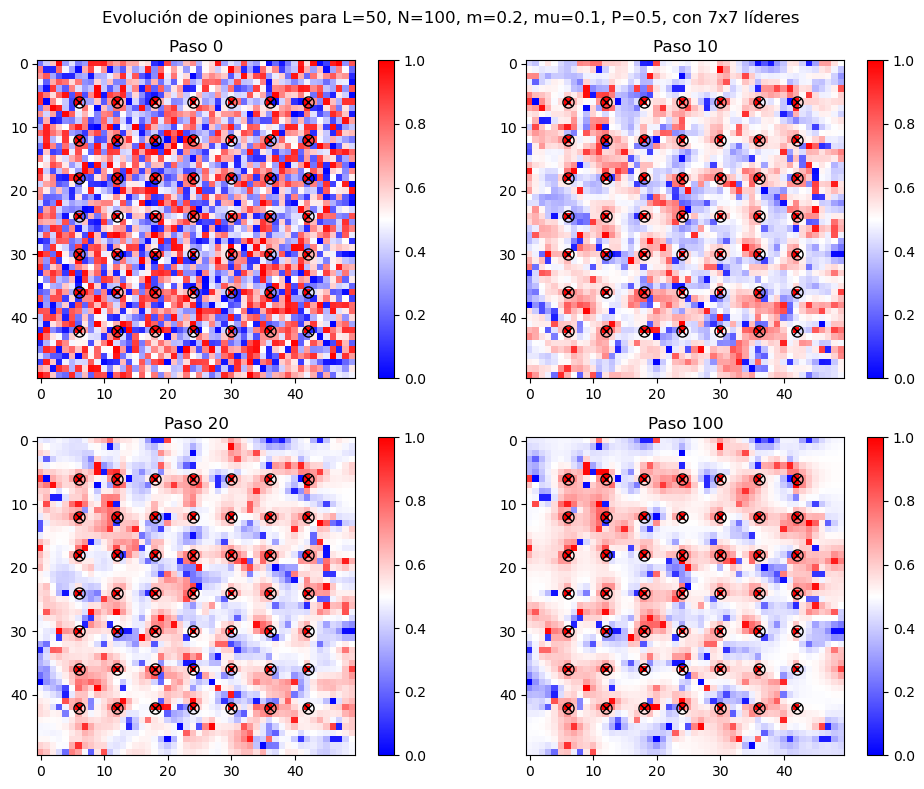

In [208]:
simulation_no_leaders.plot_evolution(equal_steps=False).savefig("../results/evolution/casoIVB.png")
# simulation_no_leaders.plot_evolution(equal_steps=False)
# simulation_with_leaders.plot_evolution()

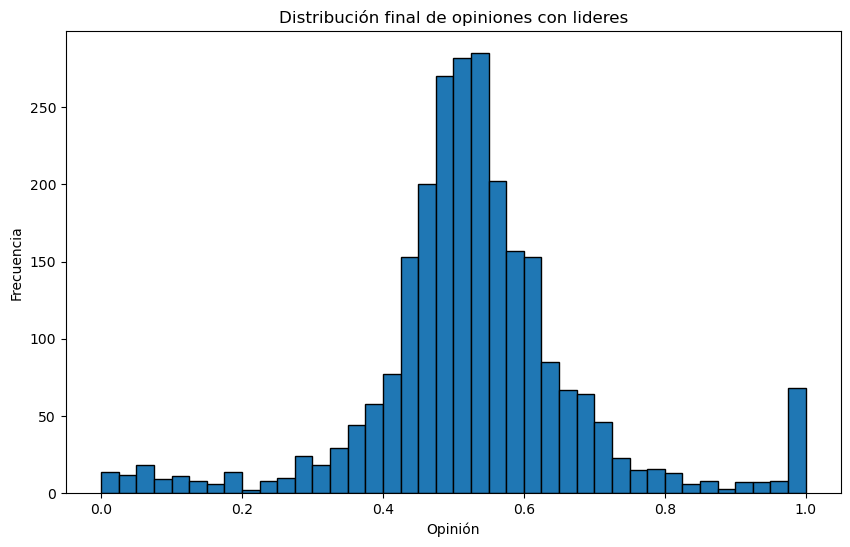

In [209]:
simulation_no_leaders.plot_histogram().savefig("../results/final_hist/casoIVB.png")
# simulation_no_leaders.plot_histogram()
# simulation_with_leaders.plot_histogram()

In [212]:
simulation_no_leaders.create_animation("../results/animations/casoIVB.gif", interval=50, fps=10)
# simulation_with_leaders.create_animation("../results/animations/opinion_evolution_with_leaders.gif", interval=50, fps=20)

MovieWriter ffmpeg unavailable; using Pillow instead.


Animación guardada en ../results/animations/casoIVB.gif


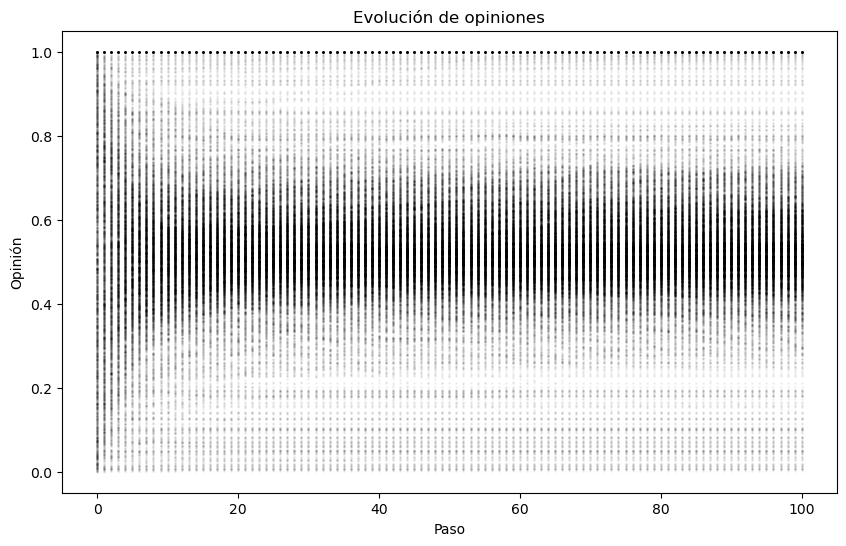

In [211]:
simulation_no_leaders.plot_scatter(color="black", alpha=0.04, s=1).savefig("../results/evolution_scatter/casoIVB.png")
# simulation_no_leaders.plot_scatter(color="black", alpha=0.04, s=1)